In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Checking current GPU

!nvidia-smi

Thu May  9 12:46:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data = FashionMNIST('data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = FashionMNIST('data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:00<00:00, 37296385.06it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5094439.61it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 16588000.12it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7302088.94it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = next(iter(train_data))

image = image.unsqueeze(0)

In [ ]:
print(image.size())

torch.Size([1, 1, 28, 28])


In [ ]:
inputX = torch.zeros((1, 1, 28, 28))
inputX[:, :, :, 14] = torch.randn((28))
inputY = torch.zeros((1, 1, 28, 28))
inputY[:, :, 14, :] = torch.randn((28))
Xweight = torch.randn((1, 28, 1))
Yweight = torch.randn((1, 1, 28))

In [ ]:
X = inputX * Xweight
Xout = softmaxX(X)
Y = inputY * Yweight
Yout = softmaxY(Y)
Out = Xout * Yout

In [ ]:
softmaxX = nn.Softmax(-1)
softmaxY = nn.Softmax(-2)

In [ ]:
X_print = to_numpy(X)
Xout_print = to_numpy(Xout)
Y_print = to_numpy(Y)
Yout_print = to_numpy(Yout)
Out_print = to_numpy(Out)

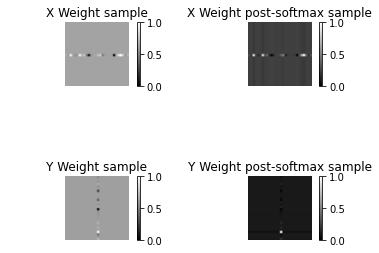

In [ ]:
fig, ax = plt.subplots(3, 2)

for x in range(3):

    for y in range(2):

        ax[x,y].axis("off")

ax[2,0].imshow(X_print[0].squeeze(-1), cmap='gray')
ax[2,0].set_title("Y Weight sample")
ax[2,1].imshow(Xout_print[0].squeeze(-1), cmap='gray')
ax[2,1].set_title("Y Weight post-softmax sample")
ax[0,0].imshow(Y_print[0].squeeze(-1), cmap='gray')
ax[0,0].set_title("X Weight sample")
ax[0,1].imshow(Yout_print[0].squeeze(-1), cmap='gray')
ax[0,1].set_title("X Weight post-softmax sample")

fig.colorbar(plt.cm.ScalarMappable().set_array(X_print[0].squeeze(-1)), cmap='gray', ax=ax[2,0])
fig.colorbar(plt.cm.ScalarMappable().set_array(Xout_print[0].squeeze(-1)), cmap='gray', ax=ax[2,1])
fig.colorbar(plt.cm.ScalarMappable().set_array(Y_print[0].squeeze(-1)), cmap='gray', ax=ax[0,0])
fig.colorbar(plt.cm.ScalarMappable().set_array(Yout_print[0].squeeze(-1)), cmap='gray', ax=ax[0,1])

fig.savefig("X_Y_weights_sketch.png")

plt.show()

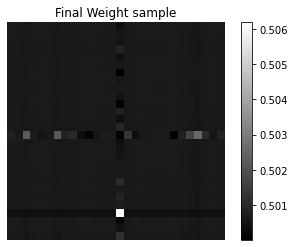

In [ ]:
plt.imshow(Out_print[0].squeeze(-1), cmap='gray')
plt.colorbar(plt.cm.ScalarMappable().set_array(Out_print[0].squeeze(-1)))
plt.axis("off")
plt.title("Final Weight sample")
plt.savefig("final_weight_sketch.png")
plt.show()

In [ ]:
class ControlA(nn.Module):
    '''
    Control Model, VGG-like architecture
    '''

    def __init__(self):
        super(ControlA, self).__init__()

        self.conv1 = nn.Conv2d(1, 100, 3, 1, 1, bias=True)
        self.conv2A = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 14x14
        self.conv3 = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv4A = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv4B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv4C = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 7x7
        self.neuron_out = nn.Linear(7*7*200, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        self.Relu = nn.ReLU()

    def forward(self, input):

        x = self.conv1(input)
        x = self.Relu(x)

        x = self.conv2A(x)
        x = self.Relu(x)
        x = self.conv2B(x)
        x = self.Relu(x)
        x = self.conv2C(x)
        x = self.Relu(x)

        x = self.conv3(x)
        x = self.Relu(x)

        x = self.conv4A(x)
        x = self.Relu(x)
        x = self.conv4B(x)
        x = self.Relu(x)
        x = self.conv4C(x)
        x = self.Relu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
class ControlB(nn.Module):
    '''
    Control Model, ResNet-like architecture
    '''

    def __init__(self):
        super(ControlB, self).__init__()

        self.conv1 = nn.Conv2d(1, 100, 3, 1, 1, bias=True)
        self.conv2A = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv3 = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 14x14
        self.conv4A = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv4B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv4C = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv5 = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 7x7
        self.neuron_out = nn.Linear(7*7*200, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        self.Relu = nn.ReLU()

    def forward(self, input):

        x = self.conv1(input)
        x = self.Relu(x)

        x = self.conv2A(x)
        r1 = self.Relu(x)
        x = self.conv2B(r1)
        r2 = self.Relu(x)
        x = self.conv2C(r2)
        x = x + r1 + r2
        x = self.Relu(x)

        x = self.conv3(x)
        x = self.Relu(x)

        x = self.conv4A(x)
        r1 = self.Relu(x)
        x = self.conv4B(r1)
        r2 = self.Relu(x)
        x = self.conv4C(r2)
        x = x + r1 + r2
        x = self.Relu(x)

        x = self.conv5(x)
        x = self.Relu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
control_modelA = ControlA().to(device)
control_modelB = ControlB().to(device)

In [ ]:
summary(control_modelA, (1, 28, 28))
summary(control_modelB, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 28, 28]           1,000
              ReLU-2          [-1, 100, 28, 28]               0
            Conv2d-3          [-1, 100, 28, 28]          90,100
              ReLU-4          [-1, 100, 28, 28]               0
            Conv2d-5          [-1, 100, 28, 28]          90,100
              ReLU-6          [-1, 100, 28, 28]               0
            Conv2d-7          [-1, 100, 14, 14]          40,000
              ReLU-8          [-1, 100, 14, 14]               0
            Conv2d-9          [-1, 200, 14, 14]         180,200
             ReLU-10          [-1, 200, 14, 14]               0
           Conv2d-11          [-1, 200, 14, 14]         360,200
             ReLU-12          [-1, 200, 14, 14]               0
           Conv2d-13          [-1, 200, 14, 14]         360,200
             ReLU-14          [-1, 200,

In [ ]:
class HeadAttention(torch.nn.Module):

    '''
    Attention Layer might be useful to detect most relevant features in the images.

    Adapted in order to be used with element-wise operations directly to images and feature maps.

    There are weights for the rows(X axis) and for the columns(Y axis). Each weight is applied to the input first in the X axis and then in the Y axis.

    At the end, the result is multiplied in order to get the proper array of weights, where aij = weight map

    So each attention weight is something like this:

      |Aij Bij Cij|
      |Dij Eij Fij|, where Xij = weight x axis * weight y axis
      |Gij Hij Iij|

    Considering that the softmax function has outputs within range [0,1], we can conclude that each weight will be within range [0,1], where 1 is the most important feature.

    OBS: This layer generates small gradients. When stacking too many layers, consider adding residual blocks and skip connections.
    '''

    def __init__(self, input_channels, input_width, input_height):

        super(HeadAttention, self).__init__()

        # Creating array of weights for element-wise operations
        self.x_weights = nn.Parameter(torch.ones((input_channels, input_width, input_height)))
        self.y_weights = nn.Parameter(torch.ones((input_channels, input_width, input_height)))
        #self.x_weights = nn.Parameter(torch.normal(0, 0.02, size=(input_channels, input_width, input_height)))
        #self.y_weights = nn.Parameter(torch.normal(0, 0.02, size=(input_channels, input_width, input_height)))

        self.batchnorm = torch.nn.BatchNorm2d(input_channels) # To compensate the lack of the sqrt(d_key) scaling factor

        #self.softmax = torch.nn.Softmax2d() # Computes softmax over each channel
        self.Xsoftmax = torch.nn.Softmax(-2)
        self.Ysoftmax = torch.nn.Softmax(-1)

    def forward(self, input):

        attention_output = []

        for batch in range(input.size(0)):

            input_data = input[batch] # (Channels, Height, Width)

            x_weights = input_data * self.x_weights
            y_weights = input_data * self.y_weights

            x_weights = self.Xsoftmax(x_weights)
            y_weights = self.Ysoftmax(y_weights)

            attention_weights = x_weights * y_weights # (Channels, Height, Width)

            attention_output.append(attention_weights.unsqueeze(0)) # (1, Channels, Height, Width)

        attention_output = torch.cat(attention_output, 0) # (Batch, Channels, Height, Width)

        attention_output = self.batchnorm(attention_output)

        attention_output = input * attention_output # (Batch, Channels, Height, Width)

        return attention_output

In [ ]:
class AttentionLayer(nn.Module):

    '''
    Applies the MultiHead Attention Arrays
    '''

    def __init__(self, n_heads, input_channels, input_width, input_height):

        self.n_heads = n_heads

        super(AttentionLayer, self).__init__()

        self.attention_heads = torch.nn.ModuleList([HeadAttention(input_channels, input_width, input_height) for i in range(n_heads)])
        self.convattention = nn.Conv2d(input_channels*n_heads, input_channels, 3, 1, 1, bias=True)
        self.batchnorm = nn.BatchNorm2d(input_channels)

        self.Relu = nn.ReLU()

    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](input)

            attention_output.append(x)

            del x

        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        #attention_output = self.batchnorm(attention_output) # BatchNorm to be removed ---> Might be decreasing the Attention performance

        attention_output = self.Relu(attention_output)

        return attention_output

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.attention1 = AttentionLayer(n_heads, 1, 28, 28)
        self.attention2 = AttentionLayer(n_heads, 1, 28, 28)
        '''self.attention3 = AttentionLayer(n_heads, 1, 28, 28)
        self.attention4 = AttentionLayer(n_heads, 1, 28, 28)'''
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

    def forward(self, input):

        x = self.attention1(input)
        x = self.attention2(x)
        #x = self.attention3(x)
       # x = self.attention4(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
from time import time, sleep

In [ ]:
toyI = torch.randn((1, 3, 1024, 1024)).to(device)
toyT = torch.ones((1, 1, 1024, 1024)).to(device)
mse = nn.MSELoss()

toyC = nn.Conv2d(3, 1, 3, 1, 1).to(device)
toyA = AttentionLayer(2, 3, 1024, 1024).to(device)

timeC, backtimeC = [], []
timeA, backtimeA = [], []

In [ ]:
for i in range(1000):

    '''sleep(2)

    startC = time()

    out = toyC(toyI)

    endC = time()

    timeC.append((endC-startC))

    loss = mse(out, toyT)

    sleep(2)

    startBC = time()

    loss.backward()

    endBC = time()

    backtimeC.append((endBC-startBC))'''

    sleep(2)

    startA = time()

    out = toyA(toyI)

    endA = time()

    timeA.append((endA-startA))

    loss = mse(out, toyT)

    sleep(2)

    startBA = time()

    loss.backward()

    endBA = time()

    backtimeA.append((endBA-startBA))

In [ ]:
timeC, backtimeC = np.array(timeC), np.array(backtimeC)
timeA, backtimeA = np.array(timeA), np.array(backtimeA)

print(timeC.mean(), timeC.std())
print(backtimeC.mean(), backtimeC.std())
print(timeA.mean(), timeA.std())
print(backtimeA.mean(), backtimeA.std())

0.00036766958236694334 3.174617114698771e-05
0.0007001910209655761 5.4138050363009406e-05
0.0010667982101440429 0.00011658403022645114
0.0011748392581939697 9.94331126400295e-05


### Control Parameters = 929,510

### Attention Model Paramaters = 10,976 (1,568 per layer + 7,840 linear layer)

In [ ]:
def weights_init(net):

    for n, p in net.named_parameters():

        if 'weight' in n:

            nn.init.normal_(p, 0, 0.02)

        else:

            nn.init.constant_(p, 0.)

In [ ]:
attention_model = AttentionModel(4).to(device)

In [ ]:
weights_init(control_modelA)
weights_init(control_modelB)
#weights_init(attention_model)
nn.init.normal_(attention_model.attention1.convattention.weight, 0, 0.02)
nn.init.normal_(attention_model.attention2.convattention.weight, 0, 0.02)

Parameter containing:
tensor([[[[-0.0054,  0.0334,  0.0005],
          [-0.0028,  0.0191, -0.0533],
          [ 0.0262, -0.0172,  0.0053]],

         [[ 0.0097,  0.0260, -0.0103],
          [ 0.0064, -0.0080,  0.0401],
          [-0.0165,  0.0318, -0.0042]],

         [[-0.0107, -0.0131,  0.0014],
          [-0.0150,  0.0001,  0.0063],
          [-0.0131, -0.0299, -0.0086]],

         [[ 0.0042, -0.0285, -0.0255],
          [-0.0193, -0.0185,  0.0144],
          [ 0.0011,  0.0318,  0.0129]],

         [[-0.0063,  0.0460, -0.0412],
          [ 0.0111,  0.0087, -0.0103],
          [ 0.0296, -0.0210, -0.0236]],

         [[-0.0070,  0.0041,  0.0285],
          [-0.0048, -0.0336, -0.0251],
          [-0.0287, -0.0061,  0.0142]],

         [[-0.0225, -0.0193, -0.0100],
          [-0.0053, -0.0257, -0.0011],
          [ 0.0015,  0.0266,  0.0142]],

         [[-0.0167, -0.0448, -0.0053],
          [-0.0308,  0.0112,  0.0049],
          [-0.0196, -0.0020,  0.0195]]]], device='cuda:0', requires

In [ ]:
optimizer_controlA = torch.optim.Adam(control_modelA.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_controlB = torch.optim.Adam(control_modelB.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True)

controlA_losses = []
controlA_accuracies = []
controlB_losses = []
controlB_accuracies = []
attention_losses = []
attention_accuracies = []

controlA_gradients = []
controlB_gradients = []
attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    controlA_epoch_loss = 0.
    controlB_epoch_loss = 0.
    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        control_modelA.zero_grad()
        control_modelB.zero_grad()
        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        controlA_output = control_modelA(image)
        controlB_output = control_modelB(image)
        attention_output = attention_model(image)

        control_lossA = loss(controlA_output, target)
        control_lossB = loss(controlB_output, target)

        controlA_losses.append(control_lossA.item())
        controlB_losses.append(control_lossB.item())

        controlA_epoch_loss += control_lossA.item()
        controlB_epoch_loss += control_lossB.item()

        control_lossA.backward()
        control_lossB.backward()

        control_gradients_avg = torch.mean(control_modelA.conv1.weight.grad)
        controlA_gradients.append(control_gradients_avg.cpu())

        control_gradients_avg = torch.mean(control_modelB.conv1.weight.grad)
        controlB_gradients.append(control_gradients_avg.cpu())

        optimizer_controlA.step()
        optimizer_controlB.step()

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1.attention_heads[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_controlA = 0.
        correct_controlB = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)
            control_modelA.eval()
            control_modelB.eval()
            attention_model.eval()
            with torch.no_grad():
                controlA_output = control_modelA(image)
                controlB_output = control_modelB(image)
                attention_output = attention_model(image)

            total += len(target)

            _, controlA_output = torch.max(controlA_output, 1)
            _, controlB_output = torch.max(controlB_output, 1)
            _, attention_output = torch.max(attention_output, 1)

            correct_controlA += (controlA_output == target).sum()
            correct_controlB += (controlB_output == target).sum()
            correct_attention += (attention_output == target).sum()

        controlA_accuracy = (correct_controlA/total)*100
        controlA_accuracies.append(controlA_accuracy.cpu())

        controlB_accuracy = (correct_controlB/total)*100
        controlB_accuracies.append(controlB_accuracy.cpu())

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())

        control_modelA.train()
        control_modelB.train()
        attention_model.train()

        print(f"{epoch+1}/{EPOCHS}")
        print(f"Control Model A Loss: {controlA_epoch_loss/(item+1)}\tControl Model A Accuracy: {controlA_accuracy}")
        print(f"Control Model B Loss: {controlB_epoch_loss/(item+1)}\tControl Model B Accuracy: {controlB_accuracy}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Control Model A Gradients: {controlA_gradients[-1]}\tControl Model B Gradients: {controlB_gradients[-1]}")
        print(f"Attention Model Gradients: {attention_gradients[-1]}")

controlA_losses = np.array(controlA_losses)
controlA_accuracies = np.array(controlA_accuracies)
controlB_losses = np.array(controlB_losses)
controlB_accuracies = np.array(controlB_accuracies)
attention_losses = np.array(attention_losses)
attention_accuracies = np.array(attention_accuracies)
controlA_gradients = np.array(controlA_gradients)
controlB_gradients = np.array(controlB_gradients)
attention_gradients = np.array(attention_gradients)

print("****TRAINING COMPLETE****")
print(f"{epoch+1}/{EPOCHS}")
print(f"Control Model A Loss MEAN: {controlA_losses.mean()}\tSTD: {controlA_losses.std()}")
print(f"Control Model A Accuracy MEAN: {controlA_accuracies.mean()}\tSTD: {controlA_accuracies.std()}")
print(f"Gradients Average MEAN: {controlA_gradients.mean()}\tSTD: {controlA_gradients.std()}")
print(f"Control Model B Loss MEAN: {controlB_losses.mean()}\tSTD: {controlB_losses.std()}")
print(f"Control Model B Accuracy MEAN: {controlB_accuracies.mean()}\tSTD: {controlB_accuracies.std()}")
print(f"Gradients Average MEAN: {controlB_gradients.mean()}\tSTD: {controlB_gradients.std()}")
print(f"Attention Model Loss MEAN: {attention_losses.mean()}\tSTD: {attention_losses.std()}")
print(f"Attention Model Accuracy MEAN: {attention_accuracies.mean()}\tSTD: {attention_accuracies.std()}")
print(f"Gradients Average MEAN: {attention_gradients.mean()}\tSTD: {attention_gradients.std()}")

1/10
Control Model A Loss: 5.738954529166222	Control Model A Accuracy: 79.80999755859375
Control Model B Loss: 5.749114534258842	Control Model B Accuracy: 81.75
Attention Model Loss: 64.51829814910889	Attention Model Accuracy: 75.83000183105469
Control Model A Gradients: -0.0016309145139530301	Control Model B Gradients: -0.003946265205740929
Attention Model Gradients: 6.356327162393427e-07
2/10
Control Model A Loss: 2.571029132604599	Control Model A Accuracy: 85.29999542236328
Control Model B Loss: 2.4261570870876312	Control Model B Accuracy: 85.58999633789062
Attention Model Loss: 37.10028302669525	Attention Model Accuracy: 79.37999725341797
Control Model A Gradients: -0.0017274438869208097	Control Model B Gradients: -0.001133084762841463
Attention Model Gradients: -1.6759757954787347e-06
3/10
Control Model A Loss: 2.1216258347034453	Control Model A Accuracy: 87.02999877929688
Control Model B Loss: 2.0217943012714388	Control Model B Accuracy: 87.27999877929688
Attention Model Loss: 33

# Models' Performance - 10 Epochs - LR = 1e-3

## Control Model A:

Loss MEAN = 0.321 ; STD = 0.257

Accuracy MEAN = 89.40% ; STD = 1.68

Gradients Avg = 1.25e-4 ; Std: 6.258e-3

## Control Model B:

Loss MEAN = 0.310 ; STD = 0.247

Accuracy MEAN = 89.65% ; STD = 1.70

Gradients Avg = 6.82e-5 ; Std: 4.61e-3

### Attention Model - 2 layers, 4 heads, with BatchNorm

Loss MEAN = 0.506 ; STD = 0.26

Accuracy MEAN = 83.66% ; STD = 2.77

Gradients Avg = 1.88e-6 ; Std = 5.45e-6

### Attention Model - 2 layers, 4 heads, WITHOUT BatchNorm

Loss MEAN = 0.558 ; STD = 0.249

Accuracy MEAN = 81.50% ; STD = 2.230

Gradients Avg = 1.52e-6 ; Std = 3.70e-6

### Attention Model - 2 layers, 8 heads, with BatchNorm

Loss MEAN = 0.529 ; STD = 0.247

Accuracy MEAN = 81.90% ; STD = 2.94%

Gradients Avg = 5.30e-7 ; Std: 5.04e-6

### Attention Model - 2 layers, 8 heads, WITHOUT Batchnorm

Loss MEAN =  ; STD =

Accuracy MEAN =  ; STD =

Gradients Avg =  ; STD =

### Attention Model - 4 layers, 4 heads, with BatchNorm

Loss MEAN = 0.496 ; STD = 0.242

Accuracy MEAN = 82.41% ; STD = 4.43%

Gradients Avg = 1.15e-6 ; Std: 6.59e-6

### Attention Model - 4 layers, 4 heads, WITHOUT BatchNorm

Loss MEAN =  ; STD =

Accuracy MEAN =  ; STD =

Gradients Avg =  ; Std:

### Attention Model - 4 layers, 8 heads, with BatchNorm

Loss MEAN = ; STD =

Accuracy MEAN =  ; STD =

Gradients Avg =  ; Std:

### Attention Model - 4 layers, 8 heads, WITHOUT BatchNorm

Loss MEAN =  ; STD =

Accuracy MEAN =  ; STD =

Gradients Avg =  ; Std:

### Attention Model - 4 layers, 16 heads, WITHOUT BatchNorm (8 Epochs)

Loss MEAN = 0.310 ; STD = 0.247

Accuracy MEAN = 89.65% ; STD = 1.70

Gradients Avg = 6.82e-5 ; Std: 4.61e-3


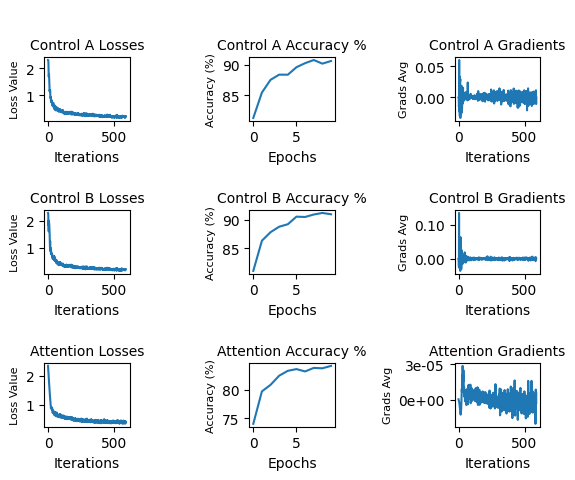

In [ ]:
# 2 layers, 4 heads + w/oBatchNorm

from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(5,5)

control_fmt = lambda x, pos: '{:.2f}'.format(x, pos)
attention_fmt = lambda x, pos: '{:.1}'.format(x, pos)

ax[0,1].axis("off")
ax[0,3].axis("off")
ax[1,0].axis("off")
ax[1,1].axis('off')
ax[1,2].axis("off")
ax[1,3].axis("off")
ax[1,4].axis('off')
ax[2,1].axis("off")
ax[2,3].axis("off")
ax[3,0].axis("off")
ax[3,1].axis("off")
ax[3,2].axis("off")
ax[3,3].axis('off')
ax[3,4].axis('off')
ax[4,1].axis("off")
ax[4,3].axis("off")

ax[0,0].plot(torch.arange(0, iters), controlA_losses)
ax[0,0].set_title("Control A Losses", fontsize=10)
ax[0,0].set_xlabel("Iterations", fontsize=10)
ax[0,0].set_ylabel("Loss Value", fontsize=8)

ax[0,2].plot(torch.arange(0, EPOCHS), controlA_accuracies)
ax[0,2].set_title("Control A Accuracy %", fontsize=10)
ax[0,2].set_xlabel("Epochs", fontsize=10)
ax[0,2].set_ylabel("Accuracy (%)", fontsize=8)

ax[0,4].plot(torch.arange(0, iters), controlA_gradients)
ax[0,4].yaxis.set_major_formatter(FuncFormatter(control_fmt))
ax[0,4].set_title("Control A Gradients", fontsize=10)
ax[0,4].set_xlabel("Iterations", fontsize=10)
ax[0,4].set_ylabel("Grads Avg", fontsize=8)

ax[2,0].plot(torch.arange(0, iters), controlB_losses)
ax[2,0].set_title("Control B Losses", fontsize=10)
ax[2,0].set_xlabel("Iterations", fontsize=10)
ax[2,0].set_ylabel("Loss Value", fontsize=8)

ax[2,2].plot(torch.arange(0, EPOCHS), controlB_accuracies)
ax[2,2].set_title("Control B Accuracy %", fontsize=10)
ax[2,2].set_xlabel("Epochs", fontsize=10)
ax[2,2].set_ylabel("Accuracy (%)", fontsize=8)

ax[2,4].plot(torch.arange(0, iters), controlB_gradients)
ax[2,4].yaxis.set_major_formatter(FuncFormatter(control_fmt))
ax[2,4].set_title("Control B Gradients", fontsize=10)
ax[2,4].set_xlabel("Iterations", fontsize=10)
ax[2,4].set_ylabel("Grads Avg", fontsize=8)

ax[4,0].plot(torch.arange(0, iters), attention_losses)
ax[4,0].set_title("Attention Losses", fontsize=10)
ax[4,0].set_xlabel("Iterations", fontsize=10)
ax[4,0].set_ylabel("Loss Value", fontsize=8)

ax[4,2].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[4,2].set_title("Attention Accuracy %", fontsize=10)
ax[4,2].set_xlabel("Epochs", fontsize=10)
ax[4,2].set_ylabel("Accuracy (%)", fontsize=8)

ax[4,4].plot(torch.arange(0, iters), attention_gradients)
ax[4,4].yaxis.set_major_formatter(FuncFormatter(attention_fmt))
ax[4,4].set_title("Attention Gradients", fontsize=10)
ax[4,4].set_xlabel("Iterations", fontsize=10)
ax[4,4].set_ylabel("Grads Avg", fontsize=8)

#fig.tight_layout()
fig.suptitle(" ")

#fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Comparison_MNIST.png")
#fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Comparison_ModelA.png")
fig.savefig("Comparison_C.png")

In [ ]:
print(attention_gradients.max())
print(attention_gradients.mean())

2.1124948e-05
1.5118502e-06


# Visualizing Outputs

In [ ]:
class VisualAttentionLayer(nn.Module):

    '''
    Applies the MultiHead Attention Arrays
    '''

    def __init__(self, n_heads, input_channels, input_width, input_height):

        self.n_heads = n_heads

        super(VisualAttentionLayer, self).__init__()

        self.attention_heads = torch.nn.ModuleList([HeadAttention(input_channels, input_width, input_height) for i in range(n_heads)])
        self.convattention = nn.Conv2d(input_channels*n_heads, input_channels, 3, 1, 1, bias=True)
        self.batchnorm = nn.BatchNorm2d(input_channels)

        self.Relu = nn.ReLU()

    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](input)

            attention_output.append(x)

            del x

        attention_output_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output_postconv = self.convattention(attention_output_preconv) # (Batch, n_channels, Height, Width)

        attention_output_prenorm = input + attention_output_postconv # (Batch, n_channels, Height, Width)
        #attention_output_prenorm = torch.zeros_like(attention_output_prenorm, device=device)

        attention_output_postnorm = self.batchnorm(attention_output_prenorm)
        #attention_output_postnorm = torch.zeros_like(attention_output_prenorm, device=device)

        #attention_output = self.Relu(attention_output_postnorm)
        attention_output = self.Relu(attention_output_prenorm)
        #attention_output = self.Relu(attention_output_postconv)

        return attention_output, attention_output_preconv, attention_output_postconv, attention_output_prenorm, attention_output_postnorm

In [ ]:
class VisualModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(VisualModel, self).__init__()

        self.attention1 = VisualAttentionLayer(n_heads, 1, 28, 28)
        self.attention2 = VisualAttentionLayer(n_heads, 1, 28, 28)
        '''self.attention3 = VisualAttentionLayer(n_heads, 1, 28, 28)
        self.attention4 = VisualAttentionLayer(n_heads, 1, 28, 28)'''
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

    def forward(self, input):

        attention_output1, attention_output_preconv1, attention_output_postconv1, attention_output_prenorm1, attention_output_postnorm1 = self.attention1(input)
        attention_output2, attention_output_preconv2, attention_output_postconv2, attention_output_prenorm2, attention_output_postnorm2 = self.attention2(attention_output1)
        '''attention_output3, attention_output_preconv3, attention_output_postconv3, attention_output_prenorm3, attention_output_postnorm3 = self.attention3(attention_output2)
        attention_output4, attention_output_preconv4, attention_output_postconv4, attention_output_prenorm4, attention_output_postnorm4 = self.attention4(attention_output3)'''

        x = attention_output2.view(attention_output2.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        out1 = (attention_output1, attention_output_preconv1, attention_output_postconv1, attention_output_prenorm1, attention_output_postnorm1)
        out2 = (attention_output2, attention_output_preconv2, attention_output_postconv2, attention_output_prenorm2, attention_output_postnorm2)
        #out3 = (attention_output3, attention_output_preconv3, attention_output_postconv3, attention_output_prenorm3, attention_output_postnorm3)
        #out4 = (attention_output4, attention_output_preconv4, attention_output_postconv4, attention_output_prenorm4, attention_output_postnorm4)

        return output, out1, out2#, out3, out4

In [ ]:
visual_model = VisualModel(8).to(device)

#visual_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/AttentionTestParameters/Attention_params_MNIST_lowLR_woBN.tar")) # This one only loads weights for Convs and BatchNorm
visual_model.load_state_dict(attention_model.state_dict())

for attention_head in range(8):

    visual_model.attention1.attention_heads[attention_head].x_weights = attention_model.attention1.attention_heads[attention_head].x_weights
    visual_model.attention1.attention_heads[attention_head].y_weights = attention_model.attention1.attention_heads[attention_head].y_weights
    visual_model.attention2.attention_heads[attention_head].x_weights = attention_model.attention2.attention_heads[attention_head].x_weights
    visual_model.attention2.attention_heads[attention_head].y_weights = attention_model.attention2.attention_heads[attention_head].y_weights
    '''visual_model.attention3.attention_heads[attention_head].x_weights = attention_model.attention3.attention_heads[attention_head].x_weights
    visual_model.attention3.attention_heads[attention_head].y_weights = attention_model.attention3.attention_heads[attention_head].y_weights
    visual_model.attention4.attention_heads[attention_head].x_weights = attention_model.attention4.attention_heads[attention_head].x_weights
    visual_model.attention4.attention_heads[attention_head].y_weights = attention_model.attention4.attention_heads[attention_head].y_weights'''

In [ ]:
def to_numpy(tensor):

    tensor = tensor.permute(0, 2, 3, 1)
    tensor = tensor.detach().cpu().numpy()
    tensor = (tensor+1.0)*0.5

    return tensor

In [ ]:
def visualize_outputs(model, image):

    model.eval()

    _, out1, out2 = model(image)

    image = to_numpy(image)

    attention_output1, attention_output1_preconv, attention_output1_postconv = to_numpy(out1[0]), to_numpy(out1[1]), to_numpy(out1[2])
    attention_output1_prenorm, attention_output1_postnorm = to_numpy(out1[3]), to_numpy(out1[4])

    attention_output2, attention_output2_preconv, attention_output2_postconv = to_numpy(out2[0]), to_numpy(out2[1]), to_numpy(out1[2])
    attention_output2_prenorm, attention_output2_postnorm = to_numpy(out2[3]), to_numpy(out2[4])

    '''attention_output3, attention_output3_preconv, attention_output3_postconv = to_numpy(out3[0]), to_numpy(out3[1]), to_numpy(out1[2])
    attention_output3_prenorm, attention_output3_postnorm = to_numpy(out3[3]), to_numpy(out3[4])

    attention_output4, attention_output4_preconv, attention_output4_postconv = to_numpy(out4[0]), to_numpy(out4[1]), to_numpy(out1[2])
    attention_output4_prenorm, attention_output4_postnorm = to_numpy(out4[3]), to_numpy(out4[4])'''

    plt.imshow(image[0].squeeze(-1), cmap='gray') # Matplotlib expects a channel dimension with 3 or 4 channels, not 1.
    plt.title("Input Image")
    plt.axis("off")
    plt.savefig("Input_image.png")
    plt.show()
    #plt.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Input_image_4layers_wBN16heads.png")

    fig, ax = plt.subplots(7, 9)

    for x in range(7):
        for y in range(9):
            ax[x,y].axis("off")

    ax[0, 0].imshow(attention_output1_preconv[0, :, :, 0], cmap='gray') # Attention: This one's shape is (Batch, Height, Width, n_heads*n_channels)
    ax[0, 0].set_title("Before Conv")
    ax[0, 2].imshow(attention_output1_postconv[0].squeeze(-1), cmap='gray')
    ax[0, 2].set_title("After Conv")
    ax[0, 4].imshow(attention_output1_prenorm[0].squeeze(-1), cmap='gray')
    ax[0, 4].set_title("Before Norm")
    ax[0, 6].imshow(attention_output1_postnorm[0].squeeze(-1), cmap='gray')
    ax[0, 6].set_title("After Norm")
    ax[0, 8].imshow(attention_output1[0].squeeze(-1), cmap='gray')
    ax[0, 8].set_title("Final Output")
    ax[2, 0].imshow(attention_output2_preconv[0, :, :, 0], cmap='gray')
    ax[2, 2].imshow(attention_output2_postconv[0].squeeze(-1), cmap='gray')
    ax[2, 4].imshow(attention_output2_prenorm[0].squeeze(-1), cmap='gray')
    ax[2, 6].imshow(attention_output2_postnorm[0].squeeze(-1), cmap='gray')
    ax[2, 8].imshow(attention_output2[0].squeeze(-1), cmap='gray')
    '''ax[4, 0].imshow(attention_output3_preconv[0, :, :, 0], cmap='gray')
    ax[4, 2].imshow(attention_output3_postconv[0].squeeze(-1), cmap='gray')
    ax[4, 4].imshow(attention_output3_prenorm[0].squeeze(-1), cmap='gray')
    ax[4, 6].imshow(attention_output3_postnorm[0].squeeze(-1), cmap='gray')
    ax[4, 8].imshow(attention_output3_prenorm[0].squeeze(-1), cmap='gray')
    ax[6, 0].imshow(attention_output4_preconv[0, :, :, 0], cmap='gray')
    ax[6, 2].imshow(attention_output4_postconv[0].squeeze(-1), cmap='gray')
    ax[6, 4].imshow(attention_output4_prenorm[0].squeeze(-1), cmap='gray')
    ax[6, 6].imshow(attention_output4_postnorm[0].squeeze(-1), cmap='gray')
    ax[6, 8].imshow(attention_output4[0].squeeze(-1), cmap='gray')'''

    print("ATTENTION LAYER 1")
    print(attention_output1_preconv[0, :, :, 0].mean(), attention_output1_preconv[0, :, :, 0].std())
    print(attention_output1_postconv[0].mean(), attention_output1_postconv[0].std())
    print(attention_output1_prenorm[0].mean(), attention_output1_prenorm[0].std())
    print(attention_output1_postnorm[0].mean(), attention_output1_postnorm[0].std())
    print(attention_output1[0].mean(), attention_output1[0].std())

    print("ATTENTION LAYER 2")
    print(attention_output2_preconv[0, :, :, 0].mean(), attention_output2_preconv[0, :, :, 0].std())
    print(attention_output2_postconv[0].mean(), attention_output2_postconv[0].std())
    print(attention_output2_prenorm[0].mean(), attention_output2_prenorm[0].std())
    print(attention_output2_postnorm[0].mean(), attention_output2_postnorm[0].std())
    print(attention_output2[0].mean(), attention_output2[0].std())

    #fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Outputs_4layers_lowLR_wBN16heads.png")
    fig.savefig("Outputs_A.png")
    plt.show()

In [ ]:
image, idx = train_loader.dataset[0]

image = image.to(device).unsqueeze(0)

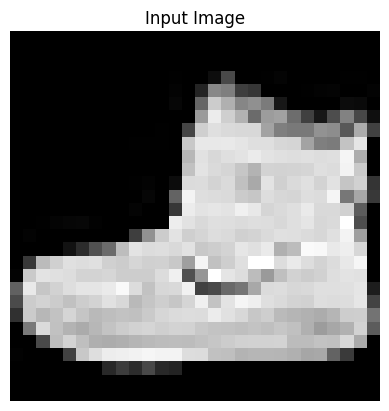

ATTENTION LAYER 1
0.5700981 0.09055234
0.6222174 0.045107163
0.8129112 0.20908952
0.81290966 0.20908847
0.8129534 0.209023
ATTENTION LAYER 2
0.615959 0.15630329
0.6222174 0.045107163
1.3063334 0.77699834
1.3063294 0.77699435
1.3063334 0.77699834


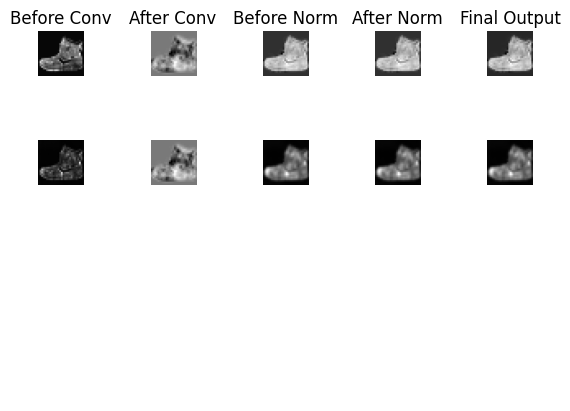

In [ ]:
visualize_outputs(visual_model, image)

From the visualization, we can come to the conclusion that the Attention Layer indeed tries to predict the most relevant features in the image. However, the BatchNormalization layer, due to its operation, ends up undoing the Attention Layer job.


It might be interesting to notice that the Attention Layer output provides more details and less blur than before being passed through the Convolution Layer.

In [ ]:
# Checking if the attention layer isn't just reproducing the input

print(attention_model.attention1.attention_heads[0].x_weights.mean(), attention_model.attention1.attention_heads[0].x_weights.std())
print(attention_model.attention1.attention_heads[0].y_weights.mean(), attention_model.attention1.attention_heads[0].x_weights.std())
print(attention_model.attention2.attention_heads[0].x_weights.mean(), attention_model.attention2.attention_heads[0].x_weights.std())
print(attention_model.attention2.attention_heads[0].y_weights.mean(), attention_model.attention2.attention_heads[0].x_weights.std())

tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0808, device='cuda:0', grad_fn=<StdBackward0>)
tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0808, device='cuda:0', grad_fn=<StdBackward0>)
tensor(1.0085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0668, device='cuda:0', grad_fn=<StdBackward0>)
tensor(1.0123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0668, device='cuda:0', grad_fn=<StdBackward0>)


In [ ]:
attention_model = AttentionModel(1).to(device)

In [ ]:
# Treinando apenas o Attention Model

weights_init(attention_model)

EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1.attention_heads[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)

            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())

        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/10
Attention Model Loss: 26.909000039100647	Attention Model Accuracy: 64.44000244140625
Attention Gradients: -1.2574955121635867e-07
2/10
Attention Model Loss: 17.630411982536316	Attention Model Accuracy: 67.31999969482422
Attention Gradients: -5.133739477969357e-07
3/10
Attention Model Loss: 14.103488385677338	Attention Model Accuracy: 70.84000396728516
Attention Gradients: -1.0006890533986734e-06
4/10
Attention Model Loss: 12.396486759185791	Attention Model Accuracy: 73.05999755859375
Attention Gradients: -1.7219334722540225e-06
5/10
Attention Model Loss: 11.299434423446655	Attention Model Accuracy: 75.33999633789062
Attention Gradients: -2.509498017388978e-06
6/10
Attention Model Loss: 10.47182184457779	Attention Model Accuracy: 77.04000091552734
Attention Gradients: -2.9303078008524608e-06
7/10
Attention Model Loss: 9.787211537361145	Attention Model Accuracy: 78.1500015258789
Attention Gradients: -3.5284681416669628e-06
8/10
Attention Model Loss: 9.198819816112518	Attention Model

In [ ]:
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)

            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

AttributeError: ignored

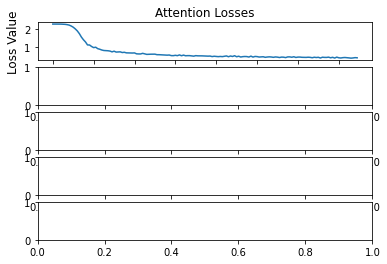

In [ ]:
fig, ax = plt.subplots(5,1)

#ax[0,0].plot(torch.arange(0, iters), control_losses)
#ax[0,0].set_title("Control Losses")
ax[0].plot(torch.arange(0, iters), attention_losses)
ax[0].set_title("Attention Losses")
ax[0].set_xlabel("Iterations", fontsize=12)
ax[0].set_ylabel("Loss Value", fontsize=12)
#ax[0].locator_param(nbins=10)
#ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
#ax[0,1].set_title("Control Accuracy %")
ax[2].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[2].set_title("Attention Accuracy %")
ax[2].set_xlabel("Epochs", fontsize=12)
ax[2].set_ylabel("Accuracy (%)", fontsize=12)
ax[2].locator_param(nbins=10)

#ax[2,0].plot(torch.arange(0, iters), control_gradients)
#ax[2,0].set_title("Control Gradients Average")
ax[4].plot(torch.arange(0, iters), attention_gradients)
ax[4].set_title("Attention Gradients Average")
ax[4].set_xlabel("Iterations", fontsize=12)
ax[4].set_ylabel("Gradients Average", fontsize=12)
ax[4].locator_param(nbins=10)

#fig.tight_layout()
fig.suptitle("2 layers without Skip-Connection")

#fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Comparison_MNIST_woBN.png")
fig.savefig("Comparison_MNIST_woSkip.png")

# Testing with Learning Rate = 0.1

In [ ]:
# Treinando apenas o Attention Model, com LR = 0.1

weights_init(attention_model)

EPOCHS = 10
#EPOCHS = 5 # For plotting outputs ---> 5~8 Epochs provide the best accuracy
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-1, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1.attention_heads[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)

            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/10
Attention Model Loss: 37.89224910736084	Attention Model Accuracy: 9.999999046325684
Attention Gradients: 6.108089564804686e-06
2/10
Attention Model Loss: 34.57592797279358	Attention Model Accuracy: 9.999999046325684
Attention Gradients: 6.108089564804686e-06
3/10
Attention Model Loss: 34.550442934036255	Attention Model Accuracy: 9.999999046325684
Attention Gradients: 6.108089564804686e-06
4/10
Attention Model Loss: 34.54980516433716	Attention Model Accuracy: 9.999999046325684
Attention Gradients: 6.108089564804686e-06
5/10
Attention Model Loss: 34.54602837562561	Attention Model Accuracy: 9.999999046325684
Attention Gradients: 6.108089564804686e-06


# Models' Performance - 10 Epochs - LR = 0.1 ---> Collapse, just like the COntrol model

## Control Model:

Loss = 4.5083

Accuracy = 88.2900

Last Gradients = 0.0020296266302466393

### Attention Model - 2 layers, 8 heads, with BatchNorm

Loss = 34.5506

Accuracy = 9.9999

Last Gradients = -0.0001

### Attention Model - 2 layers, 8 heads, WITHOUT BatchNorm

Loss = 34.5452

Accuracy = 9.9999

Last Gradients = 0.0006

### Attention Model - 2 layers, 16 heads, with Batchnorm

Loss =

Accuracy =

Last Gradients =

### Attention Model - 2 layers, 16 heads, WITHOUT BatchNorm

Loss = 34.5460

Accuracy = 9.9999

Last Gradients = 6.1080e-6

In [ ]:
fig, ax = plt.subplots(5,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[0,1].plot(torch.arange(0, iters), attention_losses)
ax[0,1].set_title("Attention Losses")
ax[2,0].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[2,0].set_title("Control Accuracy %")
ax[2,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[2,1].set_title("Attention Accuracy %")

ax[4,0].plot(torch.arange(0, iters), control_gradients)
ax[4,0].set_title("Control Gradients Average")
ax[4,1].plot(torch.arange(0, iters), attention_gradients)
ax[4,1].set_title("Attention Gradients Average")

fig.tight_layout()
fig.suptitle("Control LR = 1e-3 ; Attention LR = 1e-1\nUsing 2 layers, 8 heads + BatchNorm")

fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Comparison_MNIST.png")

# Removing BatchNorm from attention layer

In [ ]:
class HeadAttention(torch.nn.Module):

    '''
    Attention Layer might be useful to detect most relevant features in the images.

    Adapted in order to be used with element-wise operations directly to images and feature maps.

    There are weights for the rows(X axis) and for the columns(Y axis). Each weight is applied to the input first in the X axis and then in the Y axis.

    At the end, the result is multiplied in order to get the proper array of weights, where aij = weight map

    So each attention weight is something like this:

      |Aij Bij Cij|
      |Dij Eij Fij|, where Xij = weight x axis * weight y axis
      |Gij Hij Iij|

    Considering that the softmax function has outputs within range [0,1], we can conclude that each weight will be within range [0,1], where 1 is the most important feature.

    OBS: This layer generates small gradients. When stacking too many layers, consider adding residual blocks and skip connections.
    '''

    def __init__(self, input_channels, input_width, input_height):

        super(HeadAttention, self).__init__()

        # Creating array of weights for element-wise operations
        self.x_weights = torch.normal(0, 0.02, size=(input_channels, input_width, input_height), device=device, requires_grad=True)
        self.y_weights = torch.normal(0, 0.02, size=(input_channels, input_width, input_height), device=device, requires_grad=True)

        #self.batchnorm = torch.nn.BatchNorm2d(input_channels) # To compensate the lack of the sqrt(d_key) scaling factor

        #self.softmax = torch.nn.Softmax2d() # Computes softmax over each channel
        self.Xsoftmax = torch.nn.Softmax(-2)
        self.Ysoftmax = torch.nn.Softmax(-1)

    def forward(self, input):

        attention_output = []

        for batch in range(input.size(0)):

            input_data = input[batch] # (Channels, Height, Width)

            x_weights = input_data * self.x_weights
            y_weights = input_data * self.y_weights

            x_weights = self.Xsoftmax(x_weights)
            y_weights = self.Ysoftmax(y_weights)

            attention_weights = x_weights * y_weights # (Channels, Height, Width)

            attention_output.append(attention_weights.unsqueeze(0)) # (1, Channels, Height, Width)

        attention_output = torch.cat(attention_output, 0) # (Batch, Channels, Height, Width)

        #attention_output = self.batchnorm(attention_output)

        attention_output = input * attention_output # (Batch, Channels, Height, Width)

        return attention_output

In [ ]:
class AttentionLayer(nn.Module):

    '''
    Applies the MultiHead Attention Arrays
    '''

    def __init__(self, n_heads, input_channels, input_width, input_height):

        self.n_heads = n_heads

        super(AttentionLayer, self).__init__()

        self.attention_heads = torch.nn.ModuleList([HeadAttention(input_channels, input_width, input_height) for i in range(n_heads)])
        self.convattention = nn.Conv2d(input_channels*n_heads, input_channels, 3, 1, 1, bias=True)
        #self.batchnorm = nn.BatchNorm2d(input_channels)

        self.Relu = nn.ReLU()

    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](input)

            attention_output.append(x)

            del x

        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        #attention_output = self.batchnorm(attention_output) # BatchNorm to be removed ---> Might be decreasing the Attention performance

        attention_output = self.Relu(attention_output)

        return attention_output

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.attention1 = AttentionLayer(n_heads, 1, 28, 28)
        self.attention2 = AttentionLayer(n_heads, 1, 28, 28)
        #self.attention3 = AttentionLayer(n_heads, 1, 28, 28)
        #self.attention4 = AttentionLayer(n_heads, 1, 28, 28)
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

    def forward(self, input):

        x = self.attention1(input)
        x = self.attention2(x)
        #x = self.attention3(x)
        #x = self.attention4(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(16).to(device)

In [ ]:
# Treinando apenas o Attention Model

weights_init(attention_model)

EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1.attention_heads[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)

            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/10
Attention Model Loss: 27.663555026054382	Attention Model Accuracy: 63.72999572753906
Attention Gradients: -9.770253939223039e-08
2/10
Attention Model Loss: 18.10652756690979	Attention Model Accuracy: 67.98999786376953
Attention Gradients: -6.465085675699811e-07
3/10
Attention Model Loss: 14.481560945510864	Attention Model Accuracy: 70.0
Attention Gradients: -1.4438805919780862e-06
4/10
Attention Model Loss: 12.81577080488205	Attention Model Accuracy: 72.52999877929688
Attention Gradients: -2.363786279602209e-06
5/10
Attention Model Loss: 11.824866533279419	Attention Model Accuracy: 74.48999786376953
Attention Gradients: -3.364557187524042e-06
6/10
Attention Model Loss: 11.103501737117767	Attention Model Accuracy: 76.13999938964844
Attention Gradients: -4.438938049133867e-06
7/10
Attention Model Loss: 10.547686696052551	Attention Model Accuracy: 77.44000244140625
Attention Gradients: -5.571839210460894e-06
8/10
Attention Model Loss: 10.048310577869415	Attention Model Accuracy: 78.5

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/AttentionTestParameters/Control_Metrics_MNIST.pkl", 'rb') as f:
    [control_losses, control_accuracies, control_gradients] = pickle.load(f)

f.close()

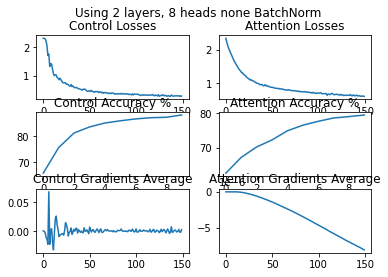

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[0,1].plot(torch.arange(0, iters), attention_losses)
ax[0,1].set_title("Attention Losses")
ax[1,0].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[1,0].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

#fig.tight_layout()
fig.suptitle("Using 2 layers, 8 heads none BatchNorm")

fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Comparison_MNIST_noneBN.png")

In [ ]:
class VisualAttentionLayer(nn.Module):

    '''
    Applies the MultiHead Attention Arrays
    '''

    def __init__(self, n_heads, input_channels, input_width, input_height):

        self.n_heads = n_heads

        super(VisualAttentionLayer, self).__init__()

        self.attention_heads = torch.nn.ModuleList([HeadAttention(input_channels, input_width, input_height) for i in range(n_heads)])
        self.convattention = nn.Conv2d(input_channels*n_heads, input_channels, 3, 1, 1, bias=True)
        self.batchnorm = nn.BatchNorm2d(input_channels)

        self.Relu = nn.ReLU()

    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](input)

            attention_output.append(x)

            del x

        attention_output_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output_postconv = self.convattention(attention_output_preconv) # (Batch, n_channels, Height, Width)

        #attention_output_prenorm = input + attention_output_postconv # (Batch, n_channels, Height, Width)
        attention_output_prenorm = torch.zeros_like(attention_output_postconv, device=device)

        #attention_output_postnorm = self.batchnorm(attention_output_prenorm)
        #attention_output_postnorm = torch.zeros_like(attention_output_prenorm, device=device)
        attention_output_postnorm = torch.zeros_like(attention_output_postconv, device=device)

        #attention_output = self.Relu(attention_output_postnorm)
        #attention_output = self.Relu(attention_output_prenorm)
        attention_output = self.Relu(attention_output_postconv)

        return attention_output, attention_output_preconv, attention_output_postconv, attention_output_prenorm, attention_output_postnorm

In [ ]:
class VisualModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(VisualModel, self).__init__()

        self.attention1 = VisualAttentionLayer(n_heads, 1, 28, 28)
        self.attention2 = VisualAttentionLayer(n_heads, 1, 28, 28)
        #self.attention3 = VisualAttentionLayer(n_heads, 1, 28, 28)
        #self.attention4 = VisualAttentionLayer(n_heads, 1, 28, 28)
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

    def forward(self, input):

        attention_output1, attention_output_preconv1, attention_output_postconv1, attention_output_prenorm1, attention_output_postnorm1 = self.attention1(input)
        attention_output2, attention_output_preconv2, attention_output_postconv2, attention_output_prenorm2, attention_output_postnorm2 = self.attention2(attention_output1)
        #attention_output3, attention_output_preconv3, attention_output_postconv3, attention_output_prenorm3, attention_output_postnorm3 = self.attention3(attention_output2)
        #attention_output4, attention_output_preconv4, attention_output_postconv4, attention_output_prenorm4, attention_output_postnorm4 = self.attention4(attention_output3)

        x = attention_output2.view(attention_output2.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        out1 = (attention_output1, attention_output_preconv1, attention_output_postconv1, attention_output_prenorm1, attention_output_postnorm1)
        out2 = (attention_output2, attention_output_preconv2, attention_output_postconv2, attention_output_prenorm2, attention_output_postnorm2)
        #out3 = (attention_output3, attention_output_preconv3, attention_output_postconv3, attention_output_prenorm3, attention_output_postnorm3)
        #out4 = (attention_output4, attention_output_preconv4, attention_output_postconv4, attention_output_prenorm4, attention_output_postnorm4)

        return output, out1, out2#, out3, out4

In [ ]:
visual_model = VisualModel(8).to(device)

#visual_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/AttentionTestParameters/Attention_params_MNIST_lowLR_woBN.tar")) # This one only loads weights for Convs and BatchNorm
visual_model.load_state_dict(attention_model.state_dict())

for attention_head in range(8):

    visual_model.attention1.attention_heads[attention_head].x_weights = attention_model.attention1.attention_heads[attention_head].x_weights
    visual_model.attention1.attention_heads[attention_head].y_weights = attention_model.attention1.attention_heads[attention_head].y_weights
    visual_model.attention2.attention_heads[attention_head].x_weights = attention_model.attention2.attention_heads[attention_head].x_weights
    visual_model.attention2.attention_heads[attention_head].y_weights = attention_model.attention2.attention_heads[attention_head].y_weights
    '''visual_model.attention3.attention_heads[attention_head].x_weights = attention_model.attention3.attention_heads[attention_head].x_weights
    visual_model.attention3.attention_heads[attention_head].y_weights = attention_model.attention3.attention_heads[attention_head].y_weights
    visual_model.attention4.attention_heads[attention_head].x_weights = attention_model.attention4.attention_heads[attention_head].x_weights
    visual_model.attention4.attention_heads[attention_head].y_weights = attention_model.attention4.attention_heads[attention_head].y_weights'''

In [ ]:
def visualize_outputs(model, image):

    model.eval()

    _, out1, out2 = model(image)

    image = to_numpy(image)

    attention_output1, attention_output1_preconv, attention_output1_postconv = to_numpy(out1[0]), to_numpy(out1[1]), to_numpy(out1[2])
    attention_output1_prenorm, attention_output1_postnorm = to_numpy(out1[3]), to_numpy(out1[4])

    attention_output2, attention_output2_preconv, attention_output2_postconv = to_numpy(out2[0]), to_numpy(out2[1]), to_numpy(out1[2])
    attention_output2_prenorm, attention_output2_postnorm = to_numpy(out2[3]), to_numpy(out2[4])

    '''attention_output3, attention_output3_preconv, attention_output3_postconv = to_numpy(out3[0]), to_numpy(out3[1]), to_numpy(out1[2])
    attention_output3_prenorm, attention_output3_postnorm = to_numpy(out3[3]), to_numpy(out3[4])

    attention_output4, attention_output4_preconv, attention_output4_postconv = to_numpy(out4[0]), to_numpy(out4[1]), to_numpy(out1[2])
    attention_output4_prenorm, attention_output4_postnorm = to_numpy(out4[3]), to_numpy(out4[4])'''

    plt.imshow(image[0].squeeze(-1), cmap='gray') # Matplotlib expects a channel dimension with 3 or 4 channels, not 1.
    plt.title("Input Image")
    plt.show()
    #plt.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Input_image_2layers_noneBN8heads.png")
    plt.savefig("Input_image_4layers_woBN8heads.png")

    fig, ax = plt.subplots(4, 5)

    for x in range(4):
        for y in range(5):
            ax[x,y].axis("off")

    ax[0, 0].imshow(attention_output1_preconv[0, :, :, 0], cmap='gray') # Attention: This one's shape is (Batch, Height, Width, n_heads*n_channels)
    ax[0, 0].set_title("Before Conv")
    ax[0, 1].imshow(attention_output1_postconv[0].squeeze(-1), cmap='gray')
    ax[0, 1].set_title("After Conv")
    ax[0, 2].imshow(attention_output1_prenorm[0].squeeze(-1), cmap='gray')
    ax[0, 2].set_title("Before Norm")
    ax[0, 3].imshow(attention_output1_postnorm[0].squeeze(-1), cmap='gray')
    ax[0, 3].set_title("After Norm")
    ax[0, 4].imshow(attention_output1[0].squeeze(-1), cmap='gray')
    ax[0, 4].set_title("Final Output")
    ax[1, 0].imshow(attention_output2_preconv[0, :, :, 0], cmap='gray')
    ax[1, 1].imshow(attention_output2_postconv[0].squeeze(-1), cmap='gray')
    ax[1, 2].imshow(attention_output2_prenorm[0].squeeze(-1), cmap='gray')
    ax[1, 3].imshow(attention_output2_postnorm[0].squeeze(-1), cmap='gray')
    ax[1, 4].imshow(attention_output2[0].squeeze(-1), cmap='gray')
    '''ax[2, 0].imshow(attention_output3_preconv[0, :, :, 0], cmap='gray')
    ax[2, 1].imshow(attention_output3_postconv[0].squeeze(-1), cmap='gray')
    ax[2, 2].imshow(attention_output3_prenorm[0].squeeze(-1), cmap='gray')
    ax[2, 3].imshow(attention_output3_postnorm[0].squeeze(-1), cmap='gray')
    ax[2, 4].imshow(attention_output3_prenorm[0].squeeze(-1), cmap='gray')
    ax[3, 0].imshow(attention_output4_preconv[0, :, :, 0], cmap='gray')
    ax[3, 1].imshow(attention_output4_postconv[0].squeeze(-1), cmap='gray')
    ax[3, 2].imshow(attention_output4_prenorm[0].squeeze(-1), cmap='gray')
    ax[3, 3].imshow(attention_output4_postnorm[0].squeeze(-1), cmap='gray')
    ax[3, 4].imshow(attention_output4[0].squeeze(-1), cmap='gray')'''

    #fig.savefig("/content/drive/MyDrive/Colab Notebooks/Images/Outputs_2layers_noneBN8heads.png")
    fig.savefig("Outputs_4layers_lowLR_woBN8heads.png")
    plt.show()

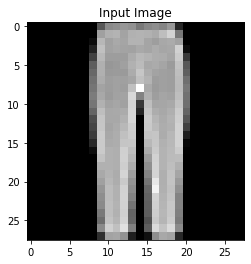

<Figure size 432x288 with 0 Axes>

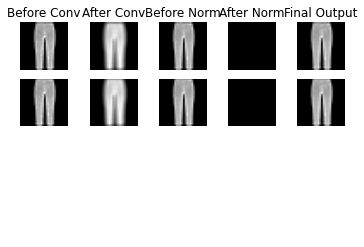

In [ ]:
image, _ = next(iter(train_loader))

image = image.to(device)

visualize_outputs(visual_model, image)

# Testando sem residual connection

In [ ]:
class AttentionLayer(nn.Module):

    '''
    Applies the MultiHead Attention Arrays
    '''

    def __init__(self, n_heads, input_channels, input_width, input_height):

        self.n_heads = n_heads

        super(AttentionLayer, self).__init__()

        self.attention_heads = torch.nn.ModuleList([HeadAttention(input_channels, input_width, input_height) for i in range(n_heads)])
        self.convattention = nn.Conv2d(input_channels*n_heads, input_channels, 3, 1, 1, bias=True)
        self.batchnorm = nn.BatchNorm2d(input_channels)

        self.Relu = nn.ReLU()

    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](input)

            attention_output.append(x)

            del x

        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention(attention_output) # (Batch, n_channels, Height, Width)

        #attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        #attention_output = self.batchnorm(attention_output) # BatchNorm to be removed ---> Might be decreasing the Attention performance

        attention_output = self.Relu(attention_output)

        return attention_output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
weights_init(attention_model)

EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
attention_wise = []
rest = []

for n, p in attention_model.named_parameters():

    if "attention_heads" in n:
        attention_wise.append(p)

    else:

        rest.append(p)

In [ ]:
weights_init(attention_model)

EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_wise, lr=1e-1, betas=(0.9, 0.999)) # Consider using lr = 1e-1
optimizer_rest = torch.optim.Adam(rest, lr=1e-3, betas=(0.9, 0.999))

attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
import pandas as pd

In [ ]:
teste = {
    'MNIST - Lr = 0.1 | 1e-3': {'Loss': 7.4980, 'Accuracy(%)': 82.12, 'Last Gradients Average': 0.0002},
    'Attention A': {'Loss': 34.5390, 'Accuracy(%)': np.nan, 'Last Gradients Average': 1.7158e-11},
    'Attention B': {'Loss': 7.5913, 'Accuracy(%)': 81.46, 'Last Gradients Average': 2.9409e-5},
    'Attention C': {'Loss': 34.5388, 'Accuracy(%)': np.nan, 'Last Gradients Average': 1.5293e-12},
    'Attention D': {'Loss': 7.4856, 'Accuracy(%)': 81.66, 'Last Gradients Average': 7.4328e-7},
    'Attention E': {'Loss': 9.8522, 'Accuracy(%)': 77.09, 'Last Gradients Average': 3.2148e-5},
    'Attention F': {'Loss': 7.4806, 'Accuracy(%)': 81.33, 'Last Gradients Average': 3.6596e-6},
    'Attention G': {'Loss': 10.0345, 'Accuracy(%)': 76.37, 'Last Gradients Average': 5.4880e-5},
    'Attention H': {'Loss': 7.7475, 'Accuracy(%)': 80.79, 'Last Gradients Average': -6.2471e-6},
}

In [ ]:
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1.attention_heads[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()
        optimizer_rest.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)

            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

KeyboardInterrupt: ignored

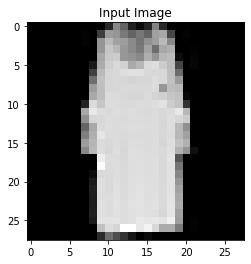

<Figure size 432x288 with 0 Axes>

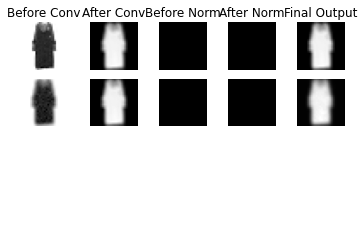

In [ ]:
image, _ = next(iter(train_loader))

image = image.to(device)

visualize_outputs(visual_model, image)

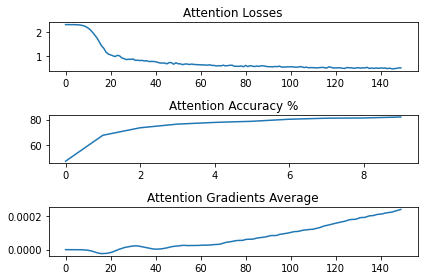

In [ ]:
fig, ax = plt.subplots(3,1)

ax[0].plot(torch.arange(0, iters), attention_losses)
ax[0].set_title("Attention Losses")
ax[1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1].set_title("Attention Accuracy %")
ax[2].plot(torch.arange(0, iters), attention_gradients)
ax[2].set_title("Attention Gradients Average")

fig.tight_layout()

In [ ]:
print(attention_model.attention1.attention_heads[0].x_weights)
print(attention_model.attention1.attention_heads[0].x_weights.mean())
print(attention_model.attention1.attention_heads[0].x_weights.std())

tensor([[[ 3.9580e-03, -3.8311e-02, -4.8303e-02,  4.6477e-03,  1.5203e-02,
           5.6363e-03,  1.1775e-02, -2.4465e-02, -8.8327e-03, -1.5764e-02,
          -6.9641e-03, -2.8125e-02,  5.8256e-04,  9.9349e-03, -1.8685e-03,
           4.0085e-02, -1.7161e-02,  3.3077e-02, -2.6377e-02, -2.5816e-02,
          -1.8063e-02,  5.5029e-02,  1.0299e-02,  6.2226e-03,  1.8526e-02,
          -2.5174e-02, -8.5081e-03,  1.5881e-02],
         [ 9.1622e-03,  2.2029e-03,  1.9056e-02,  1.2615e-02,  1.1594e-02,
           8.7708e-03, -1.3844e-02, -1.1698e-02,  3.1973e-02, -2.2967e-02,
          -4.6836e-03, -2.9616e-02, -2.1678e-02, -1.7868e-03, -1.1629e-02,
          -2.9500e-03,  2.5508e-02,  1.0748e-03,  6.1239e-03, -5.9840e-03,
          -1.7180e-02,  3.3663e-02, -7.5372e-03, -1.2432e-02,  1.3800e-02,
          -2.6459e-02, -4.1998e-02,  1.2356e-02],
         [ 5.1423e-04, -1.4945e-03,  1.8340e-02, -2.9343e-02,  1.1985e-02,
          -1.8815e-02,  1.9396e-02, -5.2649e-02, -8.5503e-03, -1.9556e-02,


In [ ]:
print(attention_model.attention1.attention_heads[0].y_weights)
print(attention_model.attention1.attention_heads[0].y_weights.mean())
print(attention_model.attention1.attention_heads[0].y_weights.std())

tensor([[[ 4.1059e-02, -3.3618e-02, -3.1608e-03,  3.1975e-02, -5.8916e-03,
           2.8771e-02, -5.8798e-03,  1.0499e-02,  1.6056e-02, -2.7055e-02,
           6.6590e-03,  3.6089e-02, -1.4131e-02, -4.2388e-02,  1.1172e-02,
           3.2053e-02,  1.5298e-03, -5.9169e-03, -7.2347e-03,  1.8987e-02,
          -1.6103e-02,  9.0733e-03, -1.6198e-03, -2.6866e-04, -2.8581e-02,
          -6.4811e-03, -6.9868e-03, -5.3974e-04],
         [-1.0974e-02,  2.3287e-02, -4.9397e-03, -3.9535e-02,  3.1771e-02,
           6.6632e-03,  3.9144e-02, -3.3812e-02,  3.9380e-04,  1.8462e-02,
           1.3653e-02, -1.6114e-02,  3.3720e-02, -9.2744e-03, -1.4125e-02,
           1.4099e-03, -2.9260e-02,  5.5338e-03,  3.1859e-02,  2.9661e-04,
          -3.0140e-02, -2.4108e-02, -2.8784e-02,  2.8278e-02,  7.9841e-03,
          -1.9659e-02, -2.7309e-03, -1.2237e-02],
         [ 3.4974e-02, -1.9654e-02,  1.6207e-02,  3.6370e-02, -9.7320e-03,
          -2.4427e-02, -2.4399e-02,  4.4131e-03,  7.6258e-03, -2.7711e-03,
